In [1]:
!pip3 install pypolyagamma

     |████████████████████████████████| 235kB 2.9MB/s 
  Created wheel for pypolyagamma: filename=pypolyagamma-1.2.2-cp36-cp36m-linux_x86_64.whl size=577202 sha256=16ef09ecd744e6c5f7c4b6d6b775c4427ffe36e4dae2314f55dfb5a5c7b23c9f
  Stored in directory: /root/.cache/pip/wheels/ff/b4/34/046d7d99529aa5fe3ab7755a0a37885e6c0d1bdc601c146bf0
Successfully built pypolyagamma


In [0]:
from pypolyagamma import PyPolyaGamma

In [4]:
!git clone https://github.com/slinderman/ssm.git
%cd ssm
!pip install -e .

Cloning into 'ssm'...
remote: Enumerating objects: 175, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 2191 (delta 114), reused 120 (delta 73), pack-reused 2016
Receiving objects: 100% (2191/2191), 16.47 MiB | 8.19 MiB/s, done.
Resolving deltas: 100% (1507/1507), done.
/content/ssm
Obtaining file:///content/ssm
  Running setup.py develop for ssm


In [0]:
from ssm import messages

In [0]:
import numpy as np
import numpy.random as npr
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from scipy.stats import multivariate_normal as MVN
import sys

In [0]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

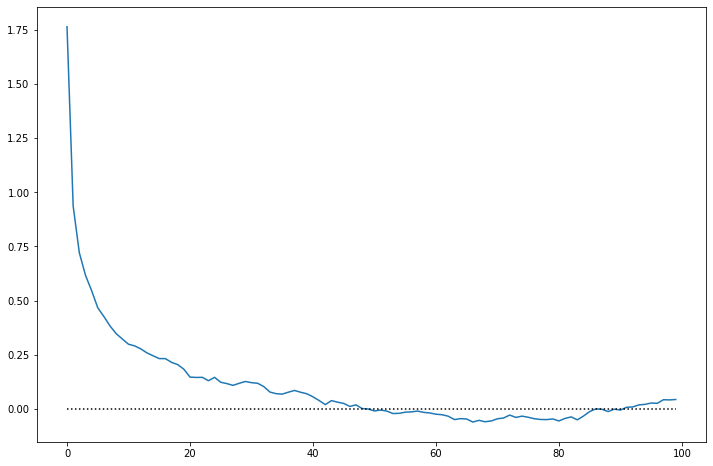

In [0]:
npr.seed(0)
N = 1
T = 100
dt = 1.0
# W = npr.randn(N, N) / (10 * N)
# B = npr.randn(N, 1)
# u = 0.1 * npr.randn(T, 1)
W = np.array([[0.95]])
B = np.zeros((N, 1))
u = np.zeros((T, 1))
x0 = npr.randn(N)
sigma = 0.01

# Sample the vanilla RNN
x = np.zeros((T, N))
x[0] = x0
for t in range(1, T):
    x[t] = np.tanh(W @ x[t-1] + B @ u[t]) + np.sqrt(dt) * sigma * npr.randn(N)

plt.figure(figsize=(12, 8))
plt.plot(x + 2 * np.arange(N))
for n in range(N):
    plt.plot(2 * n * np.ones(T), ":k")

num_parts=128


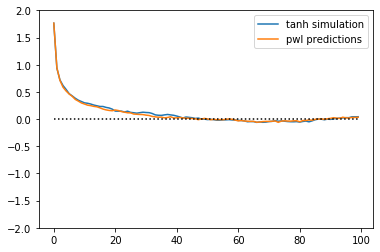

In [0]:
# Sample the vanilla RNN
pwl_tanh = PiecewiseLinearTanh(window=8,num_parts=128)
xpred = np.zeros((T, N))
xpred[0] = x0
for t in range(1, T):
    xpred[t] = pwl_tanh.f(W @ xpred[t-1] + B @ u[t]) + np.sqrt(dt) * sigma * npr.randn(N)


plt.plot(x, label="tanh simulation")
plt.plot(xpred, label='pwl predictions')
plt.ylim(-2, 2)
plt.plot(np.zeros(T), ":k")
plt.legend(loc="upper right")

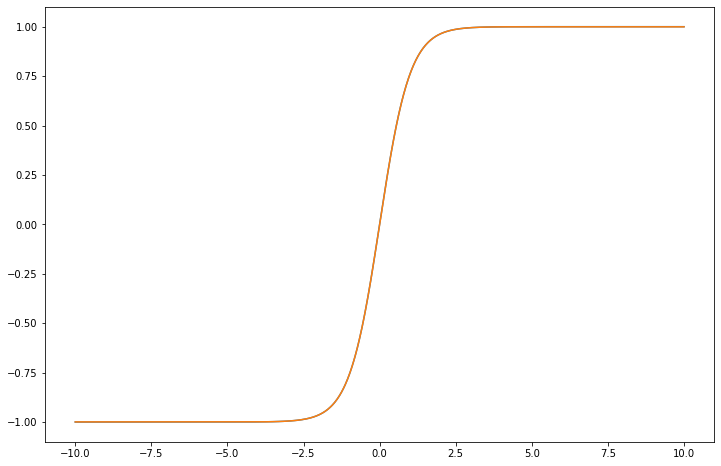

In [0]:
xx = np.linspace(-10, 10, 1000)

plt.figure(figsize=(12, 8))
plt.plot(xx, np.tanh(xx))
plt.plot(xx, pwl_tanh.f(xx))

num_parts=16
num_parts=128


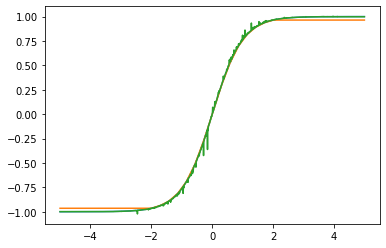

In [0]:
pwl_tanh = PiecewiseLinearTanh()
spwl_tanh = StochPiecewiseLinearTanh(num_parts=128, window=7, temp=.25)

xx = np.linspace(-5, 5, 1000)
plt.plot(xx, np.tanh(xx))
plt.plot(xx, pwl_tanh.f(xx))
plt.plot(xx, spwl_tanh.f(xx))

In [0]:
plt.plot(xx, spwl_tanh.f(xx, return_z=True)[1])

In [0]:
plt.imshow(spwl_tanh.discrete_prior(xx).T, aspect="auto")

NameError: ignored

In [0]:
# Sample the stochastic pwl tanh RNN
n_samples = 10
xpreds = np.zeros((n_samples, T, 1))
zpreds = np.zeros((n_samples, T), dtype=int)
for n in range(n_samples):
  xpreds[n, 0] = x0
  for t in range(1, T):
      # yhat, zpreds[n, t] = spwl_tanh.f(w * xpreds[n, t-1] + b, return_z=True)
      mu_pred, zpreds[n, t] = spwl_tanh.f(W @ xpreds[n, t-1] + B @ u[t], return_z=True)
      xpreds[n, t] = mu_pred + np.sqrt(dt) * sigma * npr.randn(N)

xpred_mean = np.mean(xpreds, axis=0)[:, 0]
xpred_std = np.std(xpreds, axis=0)[:, 0]

plt.figure(figsize=(12, 6))
plt.plot(x, label="tanh simulation")
h = plt.plot(xpred_mean, label='stoch pwl predictions')[0]
plt.fill_between(np.arange(T), 
                 xpred_mean - 2 * xpred_std, 
                 xpred_mean + 2 * xpred_std,
                 color=h.get_color(),
                 alpha=0.5)

plt.ylim(-2, 2)
plt.plot(np.zeros(T), ":k")
plt.legend(loc="upper right")

NameError: ignored

In [0]:

spwl_tanh = StochPiecewiseLinearTanh()
zsmpls, msmpls, Vsmpls = spwl_tanh.resample(xpreds[0, :-1, 0], xpreds[0, 1:, 0], dt * sigma**2)

# # Combine the Gaussian potentials into one
# Jsmpls = 1 / Vsmpls
# hsmpls = msmpls / Vsmpls
# Jeff = Jsmpls.sum(axis=1)
# heff = hsmpls.sum(axis=1)
# meff = heff / Jeff
# Veff = 1 / Jeff

In [0]:
plt.plot(zsmpls, label="sample")
plt.plot(zpreds[0, 1:], '--', label="true")
plt.legend()

In [0]:
plt.plot(xpreds[0])
h = plt.plot(msmpls)[0]
plt.fill_between(np.arange(T-1), 
                 msmpls - 2 * np.sqrt(Vsmpls), 
                 msmpls + 2 * np.sqrt(Vsmpls),
                 color=h.get_color(),
                 alpha=0.5)

In [0]:
# Define the piecewise linear tanh approximation
class PiecewiseLinearSigmoid(object):
    """
    Piecewise linear approximation to sigma(x) with the specified 
    window size and number of linear parts.
    """
    def __init__(self, num_parts=16, window=4):
        self.num_parts = num_parts
        print('num_parts={}'.format(num_parts))
        self.knots = np.linspace(-window, window, num_parts-1)
        self.values = sigmoid(self.knots)

        # Compute slopes and intercepts for each bin
        self.slopes = np.concatenate(([0], np.diff(self.values) / np.diff(self.knots), [0]))
        self.intercepts = np.concatenate(([self.values[0]], self.values - self.slopes[1:] * self.knots))

    def f(self, x):
        z = np.digitize(x, self.knots)
        return self.intercepts[z] + self.slopes[z] * x
        
class PiecewiseLinearTanh(PiecewiseLinearSigmoid):
    def f(self, x):
        return 2 * super(PiecewiseLinearTanh, self).f(2 * x) - 1



In [0]:
# Define the piecewise linear tanh approximation
class StochPiecewiseLinearSigmoid(PiecewiseLinearSigmoid):
    """
    Stochastic p.w.l. approximation to sigma(x) with the specified 
    window size and number of linear parts.  Here, the discrete
    part is chosen randomly based on a tree-structured stick breaking
    of the interval.
    """
    def __init__(self, num_parts=16, window=4, temp=0.25):
        super(StochPiecewiseLinearSigmoid, self).__init__(num_parts, window)
        self.temp = temp

        # Precompute the transition probabilities on a dense grid        
        # num_pts = 1000
        # x = np.linspace(-1.5 * window, 1.5 * window, num_pts)
        # p = np.ones((num_pts, num_parts))

        # Get length of binary representation (i.e. depth of tree)
        decimal, depth = np.modf(np.log2(num_parts))
        assert np.allclose(decimal, 0), "number of parts must be a power of 2."
        depth = int(depth)
        self.depth = depth

        # Get a binary representation of each of the discrete parts
        self._bs = np.unpackbits(
            np.arange(self.num_parts, 
                      dtype=np.uint8)[:, None], axis=1)[:, -(self.depth):]

        # Precompute indices of decision knots for each discrete state
        mids = 2**np.arange(self.depth - 1, -1, -1)
        lefts = np.column_stack((np.zeros(self.num_parts), 
                                 np.cumsum(self._bs[:, :-1] * mids[:-1], axis=1)))
        self._inds = np.array(lefts + mids - 1, dtype=int)

    
    def f_given_z(self, x, z):
      return self.intercepts[z] + self.slopes[z] * x
    
    def f(self, x, return_z=False):
        """
        Sample a discrete state given x, then return the corresponding
        linear function of x.
        """
        x = np.atleast_1d(x)
        z = np.zeros_like(x, dtype=int)
        shp = x.shape
        for d in range(self.depth):
            mid = 2**(self.depth-d-1) - 1
            choice = npr.rand(*shp) < sigmoid((x - self.knots[z + mid]) / self.temp)
            z += choice * (mid + 1)
        
        if return_z:
            return self.f_given_z(x,z), z
        else:
            return self.f_given_z(x,z)
        
        '''
        if return_z:
            return self.intercepts[z] + self.slopes[z] * x, z
        else:
            return self.intercepts[z] + self.slopes[z] * x
        '''

    def discrete_prior(self, x):
        """
        Get the prior on discrete states for input x
        """
        # Convert input to 1d arrays
        x = np.atleast_1d(x)
        assert x.ndim == 1
        N, = x.shape
        
        # To compute the posterior distribution of discrete states,
        # first evaluate sigmoids at each (input, knot) pair.
        s = sigmoid((x[:, None] - self.knots[None, :]) / self.temp)
        oms = 1 - s

        # Discrete state probabilities are products of sigmoids for subsets
        # of knots.
        prior = np.ones((N, self.num_parts))
        for k in range(self.num_parts):
            bk = self._bs[k]
            ik = self._inds[k]
            prior[:, k] = np.prod(s[:, ik[bk==1]], axis=1) * \
                          np.prod(oms[:, ik[bk==0]], axis=1)
        return prior

    def resample_discrete_states(self, x, y, sigmasq):
        """
        Sample discrete variable z given (input, output) pair (x, y) and 
        Gaussian noise variance sigmasq.
        """
        # Convert input to 1d arrays
        x = np.atleast_1d(x)
        N, = x.shape
        y = np.reshape(y, (N,))

        # Get the log prior on discrete states
        log_prior = np.log(self.discrete_prior(x))

        # Compute log likelihood (up to constant) under each discrete state
        yhat = x[:, None] * self.slopes + self.intercepts
        log_lkhd = -0.5 * (y[:, None] - yhat)**2 / sigmasq

        # Posterior is proportional to prior * lkhd
        log_post = log_prior + log_lkhd
        post = np.exp(log_post - logsumexp(log_post, axis=1, keepdims=True))

        self.cond_z = post ##for unit testing

        # Sample the posterior
        z = np.array([npr.choice(self.num_parts, p=pn) for pn in post])
        return z

    def resample_auxiliary_variables(self, x, z):
        # Sample the conditional distribution of the Polya-gamma auxiliary 
        # variable \omega given the input x.  Here the discrete state really
        # corresponds to a set of Bernoulli random variables.  Each one is 
        # parameterized as,
        #
        #     b_i ~ Bern(\sigma((x - \theta_i) / tau)) 
        # 
        # where \theta_i is the knot for the i-th choice.  The conditional
        # distribution is \omega ~ PG(1, (x - \theta_i) / tau)), and is 
        # independent of the binary outcome b_i. 
        b = self._bs[z]

        i = self._inds[z]
        u = (x[:, None] - self.knots[i]) / self.temp


        # Sample the auxiliary variable and compute the potential on u
        # TODO: Sample rather than just returning the mean
        #Ju = np.tanh(u / 2) / (2 * u)
        
        pg_shp = u.ravel().shape
        pg = PyPolyaGamma(seed=npr.randint(0,100000000))
        Ju = np.empty(pg_shp)        
        pg.pgdrawv(np.ones(pg_shp), u.ravel(), Ju)
        Ju = Ju.reshape(u.shape)
        
        hu = b - 0.5

        # Convert to mean parameters
        mu = hu / Ju
        Vu = 1 / Ju

        # Convert the potential on u to a potential on x.
        mx = mu * self.temp + self.knots[i]
        Vx = Vu * self.temp**2

        # Convert back to natural parameters, sum, and return mean
        Jx = np.sum(1 / Vx, axis=1)
        hx = np.sum(mx / Vx, axis = 1)
        mx = hx / Jx
        Vx = 1 / Jx
        return mx, Vx

    def resample(self, x, y, sigmasq):
        """
        Resample the discrete state and auxiliary variables for given inputs (x) 
        and outputs (y), and given noise variance sigmasq. 
        """
        # First sample the discrete states
        zs = self.resample_discrete_states(x, y, sigmasq)
        bs = self._bs[zs]

        # Then sample auxiliary variables from conditional and compute the 
        # effective Gaussian observation potential.
        mx, Vx = self.resample_auxiliary_variables(x, zs)
        return zs, mx, Vx

            


class StochPiecewiseLinearTanh(StochPiecewiseLinearSigmoid):
    def f(self, x, return_z=False):
        if return_z:
            y, z = super(StochPiecewiseLinearTanh, self).f(2 * x, return_z)
            return 2 * y - 1, z
        else:
            y = super(StochPiecewiseLinearTanh, self).f(2 * x, return_z)
            return 2 * y - 1

    def resample(self, x, y, sigmasq):
        """
        Resample the discrete states and auxiliary variables given observations
        of y = tanh(x) + N(0, sigmasq).  This is equivalent to,

            y' = sigmoid(x') + N(0, sigmasq')

        where y' = (y + 1) / 2
              x' = 2 * x
              sigmasq' = sigmasq / 4

        The output is a set of discrete state samples and Gaussian potentials
        on the input to the sigmoid, here p(z | x) ~ N(x' | mx', Vx'), which is
        equivalent to N(x | mx'/2, Vx'/4) 
        """
        zs, mx, Vx = super(StochPiecewiseLinearTanh, self).\
            resample(2 * x, (y + 1) / 2, sigmasq / 4)

        return zs, mx / 2, Vx / 4


    def x_recurrence_params(self, state, sigmasq):
      A = 4*self.slopes[state.z]*state.W[0,0]
      Bu_tilde = (state.B @ state.u[1:])[:,0,0]
      Bu = 4*self.slopes[state.z]*Bu_tilde +2*self.intercepts[state.z]-1

      
      J_ini = 1/sigmasq 
      J_ini = np.atleast_1d(J_ini)[:,None]

      J_dyn_11 = A[1:]*1/sigmasq*A[1:]

      J_dyn_21 = -A[1:]*1/sigmasq
      J_dyn_21 = J_dyn_21.reshape(-1,1,1)

      J_dyn_22 = 1/sigmasq    
      J_dyn_22 = np.atleast_1d(J_dyn_22)[:,None]

      h_ini = 1/sigmasq*(A[0]*state.x[0,0,0]+Bu[0])
      h_ini = np.atleast_1d(h_ini)

      h_dyn_1 = -Bu[1:]*1/sigmasq*A[1:]
      h_dyn_2 = Bu[1:]*1/sigmasq
      h_dyn_2 = h_dyn_2[:,None]

      return J_ini, J_dyn_11, J_dyn_21, J_dyn_22, h_ini, h_dyn_1, h_dyn_2

    def x_obs_params(self, state, sigmasq_y):
      J_obs = state.C[0,0]*1/sigmasq_y*state.C[0,0]
      h_obs = state.y[:,0,0]*1/sigmasq_y*state.C[0,0]
      J_obs = np.atleast_1d(np.ones(h_obs.shape)*J_obs).reshape(-1,1,1)
      h_obs = h_obs[:,None]
      return J_obs, h_obs

    def Wbar_recurrence_params(self, state, r, rrT, sigmasq):
      J = ((4*self.slopes[state.z][:,None,None])**2)*(1/sigmasq)*rrT      
      h = 1/sigmasq*4*self.slopes[state.z]*(state.x[1:,0,0]-(2*self.intercepts[state.z]-1))
      h = h[:,None,None]*r
      return J, h

    def gibbs_step(self, state, sigma, sigma_y, Wbar_prior, Wbar_sigma, train_weights):
      
      # 1. Sample discrete states and auxiliary variables given continuous states x and Wbar.
      #First compute the input to the tanh
      inx = state.get_inx()[:,0,0]
      iny = state.x[1:,0,0]
      state.z, ms, Vs = spwl_tanh.resample(inx, iny, sigma**2)

      '''
      ###########################
      #z unit tests
      state.z, _, _ = spwl_tanh.resample(inx, iny, sigma**2)
      log_cond1 = np.sum(np.log(self.cond_z[np.arange(len(state.z)),state.z]))
      log_joint1 = self.log_joint_nopgs(state, sigma, sigma_y, Wbar_prior, Wbar_sigma)

      state.z, _, _ = spwl_tanh.resample(inx, iny, sigma**2)
      log_cond2 = np.sum(np.log(self.cond_z[np.arange(len(state.z)),state.z]))
      log_joint2 = self.log_joint_nopgs(state, sigma, sigma_y, Wbar_prior, Wbar_sigma)

      print('z')
      print('log_joint1-log_joint2')
      print(log_joint1-log_joint2)
      print('log_cond1-log_cond2')
      print(log_cond1-log_cond2)
      sys.exit()
      ############################
      '''


      
      # 2. Sample continuous states x given (linear Gaussian) observations y and 
      #    current discrete states and auxiliary variables 

      #first Convert mean and variance on Wx + Bu to natural paramteters on x
      J_tildes = state.W[0,0] * 1/Vs[1:] * state.W[0,0]
      h_tildes = state.W[0,0]* 1/Vs[1:]*(ms[1:]- (state.B @ state.u[2:])[:,0,0]  )

      #Get recurrence natural parameters for x 
      J_ini, J_dyn_11, J_dyn_21, J_dyn_22, h_ini, h_dyn_1, h_dyn_2 = self.x_recurrence_params(state, sigma**2)
      
      #Get observation natural parameters for x
      J_obs, h_obs = self.x_obs_params(state, sigma_y**2)
          
      
      #Combine parameters
      J_dyn_11 += J_tildes
      J_dyn_11 = J_dyn_11.reshape(-1,1,1)
      h_dyn_1 += h_tildes
      h_dyn_1 = h_dyn_1[:,None]
      
      #Sample x using message passing
      log_Z_obs = np.zeros(h_obs.shape[0])

      state.x[1:,:,0] = messages.kalman_info_sample(J_ini, h_ini, 0, J_dyn_11, J_dyn_21,     
                                        J_dyn_22, h_dyn_1, h_dyn_2, 0,           
                                        J_obs, h_obs, log_Z_obs) 
      


      #3. Train weights:
      if train_weights == True:
        #discrete and auxiliary potential
        #convert mean and variance on Wbar @ rt to natural parameters on Wbar=[W,B] where r=[x_{t-1}^T, u_t^T]^T
        r, rrT = state.get_r()
        J_tildes = 1/Vs[:,None,None]*rrT
        h_tildes = 1/Vs[:,None,None]*ms[:,None,None]*r

        #recurrence potential 
        J_rec, h_rec = self.Wbar_recurrence_params(state, r, rrT, sigma**2)

        #prior potential
        J_prior = np.diag(1/(Wbar_sigma[0,:]**2))
        h_prior = (1/(Wbar_sigma**2)*Wbar_prior).reshape(-1,1)

        #Combine discrete/auxiliary, recurrence and prior
        Jw = np.sum(J_tildes+J_rec, axis=0)+J_prior
        hw = np.sum(h_tildes+h_rec, axis=0)+h_prior

        #convert to mean parameters
        Vw = np.linalg.inv(Jw)
        mw = Vw @ hw

        #Sample weights
        L = np.linalg.cholesky(Vw)
        Wbar = (mw + L @ npr.randn(*mw.shape)).T
        state.split_Wbar(Wbar)


        '''
        ################################
        #Wbar unit tests
        Wbar = mw + L @ npr.randn(*mw.shape)
        log_cond1 = MVN.logpdf(np.squeeze(Wbar), np.squeeze(mw), Vw)
        state.split_Wbar(Wbar.T)
        log_joint1,_ = self.log_joint_base(state, sigma, sigma_y, Wbar_prior, Wbar_sigma)
        Wr = np.squeeze(Wbar.T @ r)
        log_joint1 += np.sum(norm.logpdf(Wr,ms, np.sqrt(Vs) ))

        Wbar = mw + L @ npr.randn(*mw.shape)
        log_cond2 = MVN.logpdf(np.squeeze(Wbar), np.squeeze(mw), Vw)
        state.split_Wbar(Wbar.T)
        log_joint2,_ = self.log_joint_base(state, sigma, sigma_y, Wbar_prior, Wbar_sigma)
        Wr = np.squeeze(Wbar.T @ r)
        log_joint2 += np.sum(norm.logpdf(Wr,ms, np.sqrt(Vs) ))
        

        print('Wbar')
        print('log_joint1-log_joint2')
        print(log_joint1-log_joint2)
        print('log_cond1-log_cond2')
        print(log_cond1-log_cond2)
        sys.exit()
        ################################
        '''

    def gewecke_step(self, state, sigma, sigma_y, Wbar_prior, Wbar_sigma, train_weights):
      self.gibbs_step(state, sigma, sigma_y, Wbar_prior, Wbar_sigma, train_weights)

      #Samples ys for Gewecke testing
      state.y = state.C @ state.x[1:]+sigma_y*npr.randn(*state.x[1:].shape)

    def x_log_prior(self, inx, state, sigma):
      mu = 2*self.f_given_z(2*inx, state.z) - 1 
      scale = sigma * np.ones(mu.shape)
      return norm.logpdf(state.x[1:,0,0], mu, scale) 

    def y_log_prior(self, state, sigma_y):
      mu = state.C @ state.x[1:]
      scale = sigma_y * np.ones(mu.shape)
      return norm.logpdf(state.y, mu, scale)

    def Wbar_log_prior(self, state, Wbar_prior, Wbar_sigma):
      Wbar = state.get_Wbar()
      return norm.logpdf(Wbar, Wbar_prior, Wbar_sigma)

    def log_joint_base(self, state, sigma, sigma_y, Wbar_prior, Wbar_sigma):
      inx = state.get_inx()[:,0,0]
      log_like = np.sum(self.x_log_prior(inx, state, sigma))
      log_like += np.sum(self.y_log_prior(state, sigma_y))
      log_like += np.sum(self.Wbar_log_prior(state, Wbar_prior, Wbar_sigma))
      return log_like, inx
    
    def log_joint_nopgs(self, state, sigma, sigma_y, Wbar_prior, Wbar_sigma):
      log_like, inx = self.log_joint_base(state, sigma, sigma_y, Wbar_prior, Wbar_sigma)
      return log_like + np.sum(np.log(self.discrete_prior(2*inx)[np.arange(len(state.z)),state.z]))



In [0]:
class State:
  def __init__(self, y, x, W, B, u, C):
    self.x0 = x[0]
    self.x = x
    self.u = u
    self.y = y
    self.W = W
    self.B = B
    self.C = C
    self.omega = 0
    self.z = 0
    
  def get_inx(self):
    return self.W @ self.x[:-1]  + self.B @ self.u[1:]
  def get_Wbar(self):
    Wbar = np.concatenate((self.W, self.B), axis=1)
    return Wbar
  def split_Wbar(self, Wbar):
    d = self.W.shape[0]
    ud = self.B.shape[1]
    self.W = Wbar[:,:d]
    self.B = Wbar[:,d:]
  def get_r(self):
    r = np.concatenate((self.x[:-1], self.u[1:]), axis=1)
    rrT = (r[...,None]*r[:,None,:]).reshape(r.shape[0], r.shape[1], r.shape[1])
    return r, rrT

In [0]:
def plot_y_obs(y, T,T_train,  ypred_mean, ypred_std, ytrue_mean, ytrue_std, ypred2_mean, ypred2_std, Wbar_prior, Wbar_sigma, sigma, N, num_parts, temp):
  plt.figure(figsize=(12, 8))
  plt.plot(y[:,0,0], label='observed')
  
  plt.plot(ytrue_mean,color='green', label='true_mean')
  plt.fill_between(np.arange(T), 
                  ytrue_mean - 2 * ytrue_std, 
                  ytrue_mean + 2 * ytrue_std,
                  color='green',
                  alpha=0.3)
  

  plt.plot(ypred_mean, color='orange', label='gen mean using W samples')
  plt.fill_between(np.arange(T), 
                  ypred_mean - 2 * ypred_std, 
                  ypred_mean + 2 * ypred_std,
                  color='orange',
                  alpha=0.5)

  plt.plot(np.arange(T_train-1,T), ypred2_mean, color='purple', label='post_pred')

  plt.fill_between(np.arange(T_train-1,T), 
                  ypred2_mean - 2 * ypred2_std, 
                  ypred2_mean + 2 * ypred2_std,
                  color='purple',
                  alpha=0.3)
  
  plt.title('N={}, sigma={}, Wbar_prior_mean={}, Wbar_sigma={},\n num_parts={}, temp={}'.format(N, sigma,Wbar_prior,Wbar_sigma,num_parts, temp  ))
  plt.legend()

# Run Gibbs sampler 

In [85]:
#seed = np.random.randint(low=0, high=1000000)
seed = 126826#665346 #97865
print('seed={}'.format(seed))
npr.seed(seed)

num_iters = 1000
burn_rate = .8
burn_iters = int(burn_rate*num_iters)
train_weights=True
window=4 #4
numparts=4 #16
temp= .5#1#.25

N = 1
ud=1 #u' dimension
yd = 1 #y dimension
T = 200
T_train = 50

####inx = Wx_{t-1}+Bu_t, where B = [B', b] and u_t = [u_t'^T, 1]^T (includes 1 for bias term)
x0 = npr.randn(N,1)
C = np.ones((yd,N))
u_ = 1*np.ones((T, ud,1))#npr.uniform(size=(T,ud,1))#0.1*np.ones((T, ud,1))
u_[0:-1:12] = -1
u = np.concatenate((u_, np.ones((T,1,1))), axis=1)
sigma = 0.1
sigma_true = .01
sigma_y = 0.01


Wbar_prior = 0*np.ones((N,N+ud+1))
Wbar_sigma = .3*np.ones(Wbar_prior.shape)
Wbar = npr.normal(Wbar_prior, Wbar_sigma)
W = Wbar[:,:N]
B = Wbar[:,N:]

###
#B[0,0]=0
###

#obs_sample

'''
Wbar_prior_true = 0*np.ones((N,N+ud+1))
Wbar_sigma_true = .3*np.ones(Wbar_prior.shape)
Wbar_obs = npr.normal(Wbar_prior_true, Wbar_sigma_true)
W_obs = Wbar_obs[:,:N]
B_obs = Wbar_obs[:,N:]
'''
'''
lo1 = -1
hi1=-.5

lo2 = .5
hi2 = 1
'''

lo1 = -.5
hi1=.5

lo2 = -.5
hi2 = .5

W_obs = npr.uniform(low=lo1, high = hi1, size=W.shape)
B_obs = npr.uniform(low=lo2, high= hi2, size=B.shape)
print('Wobs')
print(W_obs)
print('B_obs')
print(B_obs)


##
'''
W_obs[0,0] = .03826154
B_obs[0,0] = -.06765905
B_obs[0,1] = .34957977
'''
##

'''
W_obs = W*0+.95
B_obs = B*0
#B_obs[0,1] += .8
'''

# Sample the vanilla RNN
x = np.zeros((T, N, 1))
x[0] = x0

for t in range(1, T):
    x[t] = np.tanh(W_obs @ x[t-1] + B_obs @ u[t]) + sigma_true * npr.randn(N,1)
    
y = C @ x[1:]+sigma_y*npr.randn(*x[1:].shape)





seed=126826
Wobs
[[0.3386948]]
B_obs
[[0.35447517 0.32986697]]


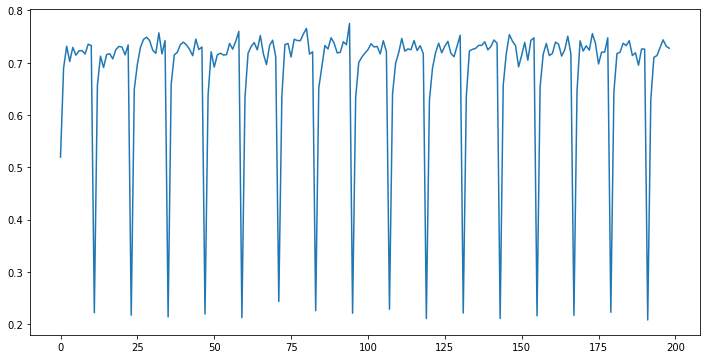

In [86]:
plt.figure(figsize=(12, 6))
plt.plot(y[:,0,0])

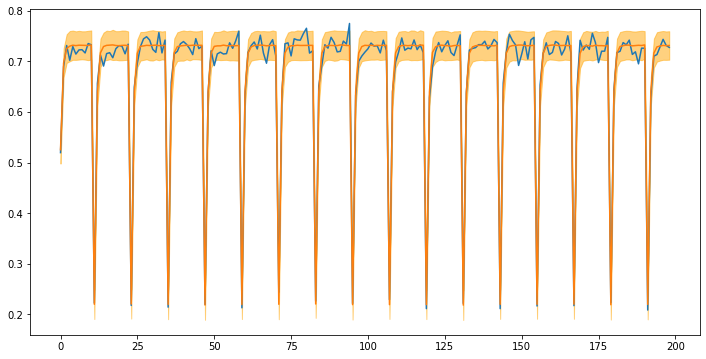

In [87]:
M=1000
x_true = np.zeros((M, T, N, 1))
y_true = np.zeros((M,T-1,yd,1))
for n in range(M):
  x_true[n,0] = x0

  #Wbar_true = npr.normal(Wbar_prior_true, Wbar_sigma_true)
  #W_true = Wbar_true[:,:N]
  #B_true = Wbar_true[:,N:]
  W_true = W_obs
  B_true = B_obs


  for t in range(1, T):
    x_true[n,t] = np.tanh(W_true @ x_true[n,t-1] + B_true @ u[t]) + sigma_true * npr.randn(N,1)
    
  y_true[n] = C @ x_true[n,1:]+sigma_y*npr.randn(*x_true[n,1:].shape)

'''
xtrue_mean = np.mean(x_true, axis=0)[:,0,0]
xtrue_std = np.std(x_true, axis=0)[:, 0,0]
'''

ytrue_mean = np.mean(y_true, axis=0)[:,0,0]
ytrue_std = np.std(y_true, axis=0)[:, 0,0]


plt.figure(figsize=(12, 6))
plt.plot(y[:,0,0], label='observed y')
plt.plot(ytrue_mean, label='model')
plt.fill_between(np.arange(T-1), 
                  ytrue_mean - 2 * ytrue_std, 
                  ytrue_mean + 2 * ytrue_std,
                  color='orange',
                  alpha=0.5)

In [88]:
spwl_tanh = StochPiecewiseLinearTanh(num_parts=numparts, window=window,  temp=temp)
state = State(y[:T_train-1], x[:T_train], W, B, u[:T_train], C)

#Burn-in period
for i in range(burn_iters):
  spwl_tanh.gibbs_step(state,sigma, sigma_y, Wbar_prior, Wbar_sigma, train_weights)
  print(i)

#Collect samples
x_samples = np.zeros((num_iters-burn_iters,T_train,N,1))
Wbar_samples = np.zeros((num_iters-burn_iters,Wbar_prior.shape[0], Wbar_prior.shape[1]))
#z_samples =  np.zeros((num_iters-burn_iters,T-1))
for i in range(num_iters-burn_iters):
  spwl_tanh.gibbs_step(state,sigma, sigma_y, Wbar_prior, Wbar_sigma, train_weights)
  x_samples[i] = state.x
  Wbar_samples[i] = state.get_Wbar()
  #z_samples[i] = state.z
  print(i)


num_parts=4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
27

In [0]:
#Generate training data
xpreds = np.zeros((num_iters-burn_iters, T, N, 1))
ypreds = np.zeros((num_iters-burn_iters, T-1, N, 1))
ypreds2 = np.zeros((num_iters-burn_iters, T_train-1, N, 1))


xpreds_test = np.zeros((num_iters-burn_iters, T, N, 1))
ypreds_test = np.zeros((num_iters-burn_iters, T-T_train, N, 1))

'''
EWbar = np.mean(Wbar_samples, axis=0)
W = EWbar[:,:N]
B = EWbar[:,N:]
'''

for n in range(num_iters-burn_iters):
  xpreds[n,0] = x0

  Wbar = Wbar_samples[n] 
  W = Wbar[:,:N]
  B = Wbar[:,N:]
  
  for t in range(1,T):
    #Using Sampled Weights
    mu_pred,_ = spwl_tanh.f(W @ xpreds[n, t-1] + B @ u[t],return_z=True)
    xpreds[n, t] = mu_pred + sigma * npr.randn(*mu_pred.shape)

  ypreds[n] = C @ xpreds[n,1:]+sigma_y*npr.randn(*xpreds[n,1:].shape)
  ypreds2[n] = C @ x_samples[n, 1:] + sigma_y*npr.randn(*x_samples[n,1:].shape)

  xpreds_test[n, T_train-1]=x_samples[n,-1] 
  for t in range(T_train,T):
    mu_pred,_ = spwl_tanh.f(W @ xpreds_test[n, t-1] + B @ u[t],return_z=True)
    xpreds_test[n, t] = mu_pred + sigma * npr.randn(*mu_pred.shape)
  ypreds_test[n] = C @ xpreds_test[n, T_train:]+sigma_y*npr.randn(*xpreds_test[n,T_train:].shape)




ypreds_mean = np.mean(ypreds, axis=0)[:,0,0]
ypreds_std = np.std(ypreds, axis=0)[:, 0,0]

ypreds2_mean = np.mean(ypreds2, axis=0)[:,0,0]
ypreds2_std = np.std(ypreds2, axis=0)[:, 0,0]

ypreds_test_mean = np.mean(ypreds_test, axis=0)[:,0,0]
ypreds_test_std = np.std(ypreds_test, axis=0)[:, 0,0]



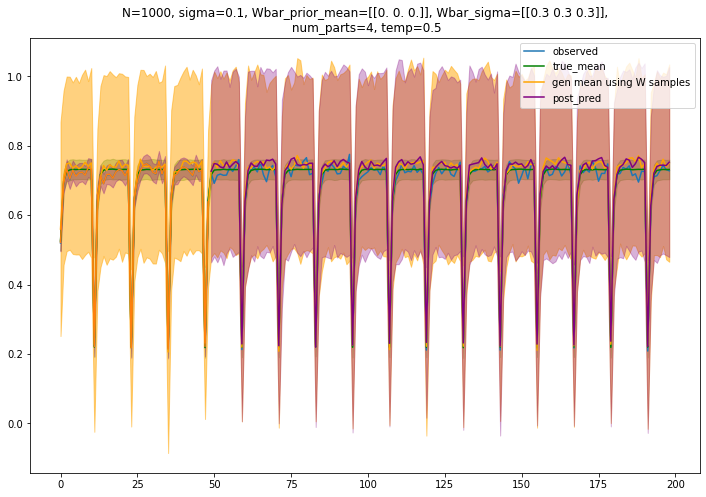

In [90]:
plot_y_obs(y, T-1,T_train, ypreds_mean, ypreds_std, ytrue_mean, ytrue_std,ypreds_test_mean, ypreds_test_std,Wbar_prior, Wbar_sigma, sigma, num_iters, numparts, temp)
plt.plot(ypreds2_mean)
plt.fill_between(np.arange(T_train-1), 
                  ypreds2_mean - 2 * ypreds2_std, 
                  ypreds2_mean + 2 * ypreds2_std,
                  color='purple',
                  alpha=0.3)

In [0]:
plt.plot(y[:,0,0])

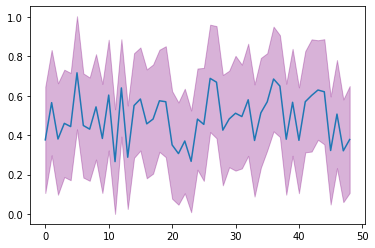

In [24]:
plt.plot(ypreds2_mean)
plt.fill_between(np.arange(T_train-1), 
                  ypreds2_mean - 2 * ypreds2_std, 
                  ypreds2_mean + 2 * ypreds2_std,
                  color='purple',
                  alpha=0.3)

In [0]:
x_samples_mean = np.mean(x_samples, axis=0)[:,0,0]
x_samples_std = np.std(x_samples, axis=0)[:, 0,0]

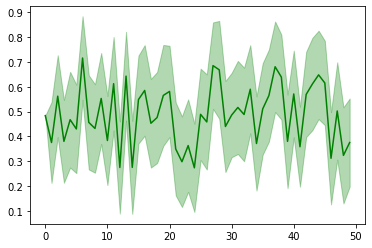

In [27]:
  plt.plot(x_samples_mean,color='green', label='true_mean')
  plt.fill_between(np.arange(T_train), 
                  x_samples_mean - 2 * x_samples_std, 
                  x_samples_mean + 2 * x_samples_std,
                  color='green',
                  alpha=0.3)
  
  #post X_samples

In [0]:
xpreds_prior = np.zeros((num_iters-burn_iters, T, N, 1))



for n in range(num_iters-burn_iters):
  xpreds_prior[n,0] = x0

  Wbar = npr.normal(Wbar_prior, Wbar_sigma)
  W = Wbar[:,:N]
  B = Wbar[:,N:]

  
  for t in range(1,T):
    #Using Sampled Weights
    mu_pred,_ = spwl_tanh.f(W @ xpreds_prior[n, t-1] + B @ u[t],return_z=True)
    xpreds_prior[n, t] = mu_pred + sigma * npr.randn(*mu_pred.shape)

xpreds_prior_mean = np.mean(xpreds_prior[:,:T_train], axis=0)[:,0,0]
xpreds_prior_std = np.std(xpreds_prior[:,:T_train], axis=0)[:, 0,0]

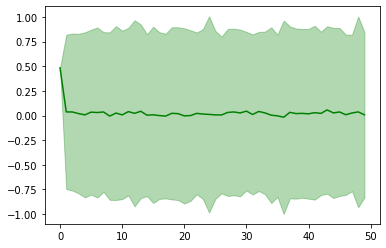

In [36]:
plt.plot(xpreds_prior_mean,color='green', label='true_mean')
plt.fill_between(np.arange(T_train), 
                  xpreds_prior_mean - 2 * xpreds_prior_std, 
                  xpreds_prior_mean + 2 * xpreds_prior_std,
                  color='green',
                  alpha=0.3)

#prior x

In [0]:
x_preds_mean = np.mean(xpreds[:,:T_train], axis=0)[:,0,0]
x_preds_std = np.std(xpreds[:,:T_train], axis=0)[:, 0,0]

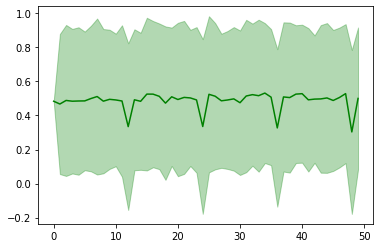

In [31]:
  plt.plot(x_preds_mean,color='green', label='true_mean')
  plt.fill_between(np.arange(T_train), 
                  x_preds_mean - 2 * x_preds_std, 
                  x_preds_mean + 2 * x_preds_std,
                  color='green',
                  alpha=0.3)
  
  #X prior (using posterior weights though)

In [0]:
xpreds_test_mean = np.mean(xpreds_test[:,T_train-1:], axis=0)[:,0,0]
xpreds_test_std = np.std(xpreds_test[:,T_train-1:], axis=0)[:, 0,0]

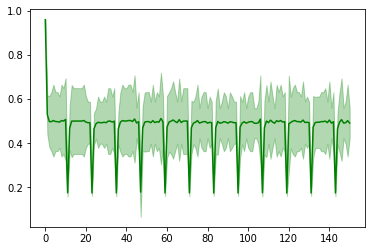

In [84]:
plt.plot(xpreds_test_mean,color='green', label='true_mean')
plt.fill_between(np.arange(T-T_train+1), 
                  xpreds_test_mean - 2 * xpreds_test_std, 
                  xpreds_test_mean + 2 * xpreds_test_std,
                  color='green',
                  alpha=0.3)

